# Darcy problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
import time

from scipy import io
from matplotlib import cm

from RF import *

In [2]:
def get_data(filename, ndata):
    # 5->85x85, 6->71x71, 7->61x61, 10->43x43, 12->36x36, 14->31x31, 15->29x29
    r = 15
    s = int(((421 - 1) / r) + 1)

    # Data is of the shape (number of samples = 1024, grid size = 421x421)
    data = io.loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float64) #* 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float64) * 100
    # The dataset has a mistake that the BC is not 0.
    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)
    #x = (x_branch, grid)
    y = y.reshape(ndata, s * s)
    return x_branch, y, grid

In [3]:
x_train, y_train, grid = get_data("piececonst_r421_N1024_smooth1.mat", 1000)
x_test, y_test, grid = get_data("piececonst_r421_N1024_smooth2.mat", 200)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1000, 841), (1000, 841), (200, 841), (200, 841))

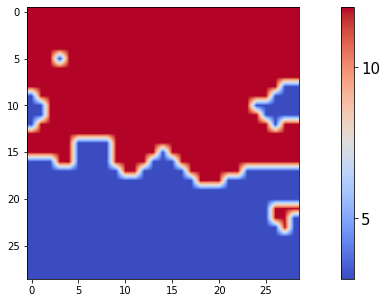

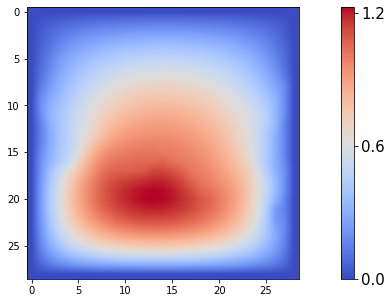

In [11]:
# Visualization
idx = 1

# training input
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
im = ax1.imshow(x_train[idx].reshape(29,29), interpolation='bilinear', cmap= "coolwarm")
plt.grid(visible=False)
cb = fig.colorbar(im, ax=ax1,ticks=[5,10])
cb.ax.tick_params(labelsize=15)
plt.savefig('Darcy1_input.pdf', bbox_inches = 'tight')

# training output
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
im = ax1.imshow(y_train[idx].reshape(29,29), interpolation='bilinear', cmap= "coolwarm")
plt.grid(visible=False)
cb = fig.colorbar(im, ax=ax1,ticks=[0,0.6,1.2])
cb.ax.tick_params(labelsize=15)
plt.savefig('Darcy1_output.pdf', bbox_inches = 'tight')

## Random Feature Model

In [12]:
############################ Cauchy Random Feature
# number of features
N = 100000
# scaling parameter gamma
gamma = 2e-4
# generate random feature matrix
x_train_RF, x_test_RF = RF_Cauchy(gamma, N, x_train, x_test)
# train a linear regression model
model = Ridge(alpha=1e-12)
start = time.time()
model.fit(x_train_RF, y_train)
end = time.time()
pred = model.predict(x_test_RF)
# report relative prediction error and clock time
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
print(f'Test error of Cauchy random feature model is {e}.\n')
print(f'Clock time is {end-start} seconds')

Test error of Cauchy random feature model is 0.030808947162175727.

Clock time is 2.480898141860962 seconds


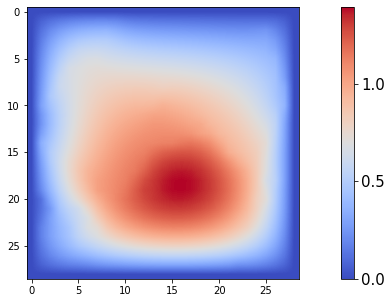

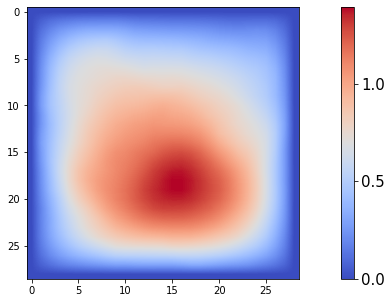

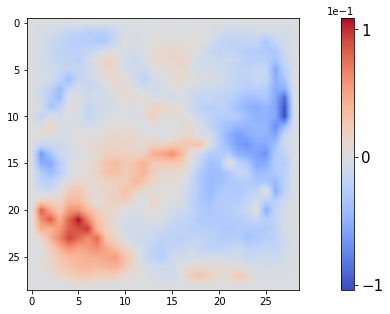

In [24]:
# Visualize the result
idx = 8

test = y_test[idx].reshape(29,29)
prediction = pred[idx].reshape(29,29)
error = prediction - test

# test
fig, ax = plt.subplots(1,1, figsize=(15,5))
im = ax.imshow(test, interpolation='bilinear', cmap= "coolwarm")
plt.grid(visible=False)
cb = fig.colorbar(im, ax=ax, ticks=[0,0.5,1,1.5])
cb.ax.tick_params(labelsize=15)
plt.savefig('Darcy1_test.pdf', bbox_inches = 'tight')

# prediction
fig, ax = plt.subplots(1,1, figsize=(15,5))
im = ax.imshow(prediction, interpolation='bilinear', cmap= "coolwarm")
plt.grid(visible=False)
cb = fig.colorbar(im, ax=ax, ticks=[0,0.5,1,1.5])
cb.ax.tick_params(labelsize=15)
plt.savefig('Darcy1_prediction.pdf', bbox_inches = 'tight')

# pointwise error
fig, ax = plt.subplots(1,1, figsize=(15,5))
im = ax.imshow(error, interpolation='bilinear', cmap= "coolwarm")
plt.grid(visible=False)
cbar = fig.colorbar(im, ax=ax, ticks=[-0.1,0,0.1])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=15)
plt.savefig('Darcy1_error.pdf', bbox_inches = 'tight')

In [6]:
########################### Gaussian Random Feature

from sklearn.kernel_approximation import RBFSampler
rbf_feature = RBFSampler(gamma=0.00001, n_components=5000, random_state=1)
X_train_RBF = rbf_feature.fit_transform(x_train)
X_test_RBF = rbf_feature.transform(x_test)

model = Ridge(alpha=1e-12)
start = time.time()
model.fit(X_train_RBF, y_train)
end = time.time()
pred = model.predict(X_test_RBF)

e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

print(f'Prediction error is {e}. \n')
print(f'Computation time is {end-start} seconds')


Prediction error is 0.03741616756954167. 

Computation time is 0.17376184463500977 seconds


## Kernel Method

In [11]:
##################### RBF kernel
bandwidth = 10
kernel = RBF(length_scale = bandwidth)
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

start = time.time()
model.fit(x_train, y_train)
end = time.time()
pred = model.predict(x_test)

e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

print(f'Error is {e}. \n')
print(f'Computation time is {end-start} seconds')


Error is 0.04925570920975694. 

Computation time is 110.60075068473816 seconds


In [14]:
##################### Matern kernel
kernel = Matern(nu = 2.5, length_scale = 10)
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

start = time.time()
model.fit(x_train, y_train)
end = time.time()
pred = model.predict(x_test)

e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

print(f'Error is {e}. \n')
print(f'Computation time is {end-start} seconds')

Error is 0.04473035447694004. 

Computation time is 88.13412308692932 seconds
